In [2]:
import pandas as pd
from textblob import TextBlob
import logging
import numpy as np
from numpy import random
import gensim
import nltk
import lxml
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

%matplotlib inline

ig = pd.read_csv("../dataset/tsv/event_ig_p5y.tsv", sep="\t")
searchfor = [" food "," eat "," makan "," steam "," boil "," ingredient "," roast "," chicken "," beef "," pork "," rice "," noodle "]
ig_food = ig[ig['post_caption'].str.contains('|'.join(searchfor), case=False, na=False)]
ig_food['sentiment'] = ig_food['post_caption'].apply(lambda tweet: TextBlob(tweet).sentiment)
print(ig_food['post_caption'].values[2], ig_food['sentiment'].values[2]) # to read post and their sentiments

/Users/vincentleonardo/.virtualenvs/2021-11_Synthesis_Sustainability/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/vincentleonardo/.virtualenvs/2021-11_Synthesis_Sustainability/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Surprise to see food hanging on gate this morning.  Thank you to my sweet nice neighbour @anonymised_user  for yummy Raya breakfast.  Sentiment(polarity=0.475, subjectivity=0.825)


/var/folders/x1/zp6kq1kj15v_md17wpr_q_n40000gn/T/ipykernel_60463/1529438814.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig_food['sentiment'] = ig_food['post_caption'].apply(lambda tweet: TextBlob(tweet).sentiment)


In [3]:
ig_food.head()

,user_id,user_name,post_id,post_shortcode,post_type,post_date,post_caption,post_tagged_users,post_hashtags,post_mentions,post_comments,post_likes,segment_name,sentiment
1,5db747f4e877ca2f15e72df13b06fd562df48403b95392...,thick-curassow-of-stimulating-authority,2579202108475507200,CPLKqcHnwJx,image,2021-05-22 12:01:12,I start to play with all kinds of ingredients ...,NaN,NaN,NaN,1.0,18.0,Optimistic Providers,"(0.25, 0.75)"
11,5db747f4e877ca2f15e72df13b06fd562df48403b95392...,portable-strict-hedgehog-from-saturn,2466869157390242304,CI8FG25nNLh,image,2020-12-18 12:15:41,Thank you @anonymised_user for the Advance Chr...,NaN,NaN,NaN,1.0,21.0,Optimistic Providers,"(-0.6, 0.95)"
27,5db747f4e877ca2f15e72df13b06fd562df48403b95392...,busy-teal-wapiti-of-education,2315810443056404992,CAjaVQJhFka,image,2020-05-24 02:08:59,Surprise to see food hanging on gate this morn...,NaN,NaN,NaN,0.0,26.0,Optimistic Providers,"(0.475, 0.825)"
29,5db747f4e877ca2f15e72df13b06fd562df48403b95392...,vague-esoteric-labrador-of-elegance,2282467869361281280,B-s9G8khZt-,image,2020-04-08 02:03:14,@anonymised_user DAY 1 : HBL home canteen foo...,NaN,NaN,NaN,1.0,18.0,Optimistic Providers,"(0.0, 0.0)"
60,7d47b5c439cc78762803f97b3a22f91ab411ab1ca05af4...,phenomenal-optimal-anteater-of-force,2503599011410180096,CK-kglHH3XI,image,2021-02-07 04:31:21,Love this rice bag bucket hat!!! Fits nicely i...,NaN,#vivicheosg|#cute|#ricebagcollection|#loveyour...,NaN,4.0,45.0,Optimistic Providers,"(0.5553125, 0.6599999999999999)"


In [4]:
ig_food.post_caption = ig_food.post_caption.astype('str')
ig_food = ig_food[ig_food['segment_name'].notna()]
ig_food['post_caption'].apply(lambda x: len(x.split(" "))).sum()

/Users/vincentleonardo/.virtualenvs/2021-11_Synthesis_Sustainability/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


2161946

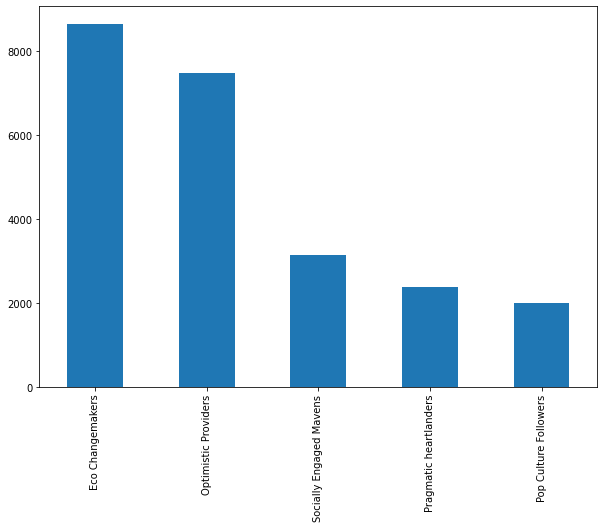

In [5]:
plt.figure(figsize=(10,7))
ig_food.segment_name.value_counts().plot(kind='bar');

(array([1.1675e+04, 3.6530e+03, 2.5200e+03, 1.4700e+03, 1.1340e+03,
        6.8200e+02, 5.6400e+02, 3.4900e+02, 2.7000e+02, 1.9500e+02,
        1.7500e+02, 1.2100e+02, 1.2100e+02, 9.3000e+01, 7.7000e+01,
        5.6000e+01, 3.8000e+01, 5.1000e+01, 3.5000e+01, 3.4000e+01,
        2.7000e+01, 2.1000e+01, 1.8000e+01, 1.8000e+01, 1.6000e+01,
        1.1000e+01, 1.6000e+01, 1.2000e+01, 8.0000e+00, 1.6000e+01]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30.]),
 <BarContainer object of 30 artists>)

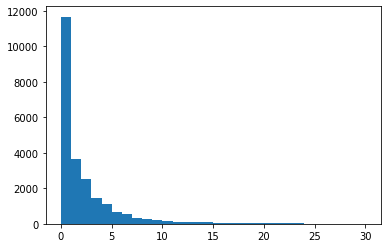

In [11]:
plt.hist(ig_food.post_comments[ig_food.post_comments <= 30], bins=30)

# Using BERT

In [19]:
# model_name = "bert-base-multilingual-uncased"
# max_length = 512

In [20]:
# from transformers import BertTokenizerFast

ModuleNotFoundError: No module named 'transformers'

# Using D2V/T2V

In [12]:
# note: slower students may wish to skip this step to finish the lab in class
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

# load a list of stop words
nltk.download('stopwords')


REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string 
        return: modified initial string
    """
    text = BeautifulSoup(text, 'html.parser').text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vincentleonardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
from tqdm import tqdm
from gensim.models import doc2vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

In [17]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [13]:
ig_food['post_caption'] = ig_food['post_caption'].apply(clean_text)

In [15]:
ig_food.post_caption.values[10]

'papa 37yo whos abit grouchy age always complaining #nellwynlittlegirl 4yo #nykolelittle2girl 2yo climbing head yet always willing eat dishes food girls love everyday #ellyoctcasting2019 anonymised_user l'

In [18]:
X_train, X_test, y_train, y_test = train_test_split(ig_food.post_caption, ig_food.segment_name, random_state=0, 
                                                    test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [19]:
model_dbow = doc2vec.Doc2Vec(dm=0, vector_size=300, negative=5, min_count=2, alpha=0.045, 
                     min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 23598/23598 [00:00<00:00, 3061086.96it/s]


In [20]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), 
                     total_examples=len(all_data), 
                     epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 23598/23598 [00:00<00:00, 7460966.82it/s]


In [21]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [36]:
model_dbow.wv.most_similar(positive=['much', 'food'])

[('rendang', 0.21651415526866913),
 ('vegetarianblk', 0.2162775695323944),
 ('8509follow', 0.2116427719593048),
 ('margarita', 0.2086995393037796),
 ('fig', 0.20863866806030273),
 ('humankind', 0.2052045315504074),
 ('mengelakkan', 0.2037886679172516),
 ('#leicha', 0.2033901810646057),
 ('thing', 0.20319943130016327),
 ('bermacammacam', 0.19898974895477295)]

/Users/vincentleonardo/.virtualenvs/2021-11_Synthesis_Sustainability/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/vincentleonardo/.virtualenvs/2021-11_Synthesis_Sustainability/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


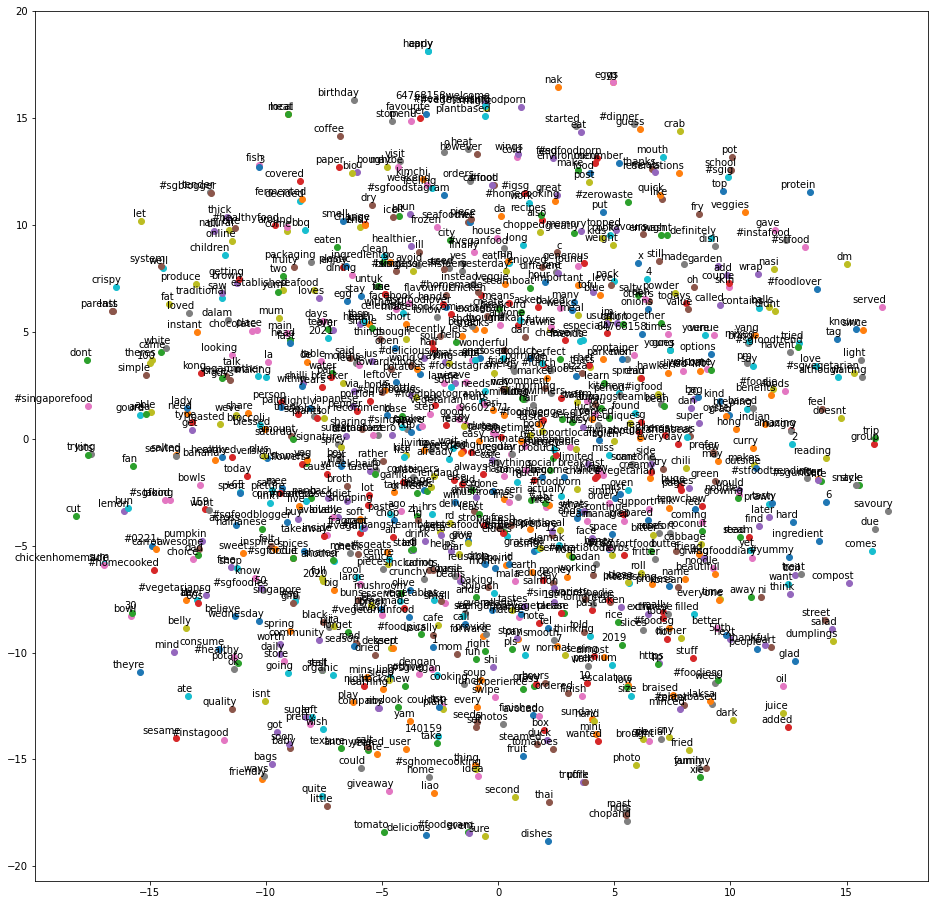

<Figure size 7200x7200 with 0 Axes>

<Figure size 7200x7200 with 0 Axes>

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model):
	"Creates and TSNE model and plots it"
	
#     fyi: to test specific labels instead of all the words in the vocab: 
#     labels = ['king', 'queen', 'prince', 'farmer', 'blue', 'red']
#     tokens = []
#     for label in labels: 
#         tokens.append(model[label])

	labels = []
	tokens = []
	

	# to speed up the process, let's limit to the first 100 elements
	count = 0
	for word in model.wv.key_to_index:
		# store the word embeddings of the words 
		# tokens.append(model[word])
		# # keep track of the labels too so that we can plot it in the graph below
		# labels.append(word)
		if count < 1000:
		    # store the word embeddings of the words 
		    tokens.append(model[word])
		    # keep track of the labels too so that we can plot it in the graph below
		    labels.append(word)
		    count = count+1

	# define the parameters of the tsne model
	tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
	
	# for the embeddings of our tokes to the tsne model
	new_values = tsne_model.fit_transform(tokens)


	# Now let's plot the tsne projects for each of the tokens in 2D
	x = []
	y = []
	for value in new_values:
		x.append(value[0])
		y.append(value[1])
		
	plt.figure(figsize=(16, 16)) 
	for i in range(len(x)):
		plt.scatter(x[i],y[i])
		plt.annotate(labels[i],
					 xy=(x[i], y[i]),
					 xytext=(5, 2),
					 textcoords='offset points',
					 ha='right',
					 va='bottom')
	plt.show()
	
tsne_plot(model_dbow)
plt.figure(figsize=[100, 100])